In [3]:
import numpy as np
import scipy as sc
from numba import njit, jit
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


In [4]:

mass = 48
N = 864

In [26]:
def initialisation(T, rho):
    M = (N/4)**(1/3)
    L = (N/rho)**(1/3)
    a = L/M
    vel = np.random.normal(0, np.sqrt(T/mass), 3*N)

    v0 = np.zeros(3)
    for i in range(N):
        v0 += vel[3*i:3*i+3]
    v0 /= N

    for i in range(N):
        vel[3*i:3*i+3] -= v0
    

    x0 = np.zeros(3*N)

    for j in range(12):
        for k in range(12):
            for l in range(6):
                x0[3*(72*j + 6*k + l) + 2] = 1e-10 + j/2 * a + j%2*a/2
                
                if j%2==0:
                    x0[3*(72*j + 6*k + l) + 0] = 1e-10 + (l * a + k%2 * a/2)
                    x0[3*(72*j + 6*k + l) + 1] = 1e-10 + ((k)//2 * a + k%2*a/2)

                else:
                    x0[3*(72*j + 6*k + l) + 0] = 1e-10 + (l * a + k%2 * a/2) +(a/2 - k%2*a)
                    x0[3*(72*j + 6*k + l) + 1] = 1e-10 + ((k)//2 * a + k%2*a/2)

    return x0, vel, a, L

@njit(fastmath=True)
def melting(pos, a):
    return np.sum(np.cos(4*np.pi/a * pos))

@njit(fastmath=True)
def dLJ(d):
    return 48 * (d**(-14) -  0.5 * d**(-8))

@njit(fastmath=True)
def force(pos, L, check=0):
    f = np.zeros(3*N)
    g = np.zeros(50)
    p = 0
    if check == 0:
        for i in range(N):
            for j in range(i+1, N):
                r = np.ones(3)
                for k in range(3):
                    r[k] = pos[3*j+k]
                    if abs(pos[3*i+k] - pos[3*j+k]) < L/2:
                        r[k] = pos[3*j+k]
                    elif pos[3*i+k] - pos[3*j+k] > L/2:
                        r[k] = pos[3*j +k] + L
                    elif pos[3*i+k] - pos[3*j+k] < -L/2:
                        r[k] = pos[3*j +k] - L

                d = np.linalg.norm(pos[3*i:3*i+3] - r)

                if (d < 2.5):
                    for p in range(50):
                        if d > p*0.05 and d <= (p+1)*0.05:
                            g[p] +=1
                            break
                    
                    f[3*i:3*i+3] += dLJ(d) * (pos[3*i:3*i+3] - r)
                    f[3*j:3*j+3] -= dLJ(d) * (pos[3*i:3*i+3] - r)
    # elif check != 0:
    #     for i in range(N):
    #         for j in array[i]:
    #             r = np.ones(3)
    #             for k in range(3):
    #                 r[k] = pos[3*j+k]
    #                 if abs(pos[3*i+k] - pos[3*j+k]) < L/2:
    #                     r[k] = pos[3*j+k]
    #                 elif pos[3*i+k] - pos[3*j+k] > L/2:
    #                     r[k] = pos[3*j +k] + L
    #                 elif pos[3*i+k] - pos[3*j+k] < -L/2:
    #                     r[k] = pos[3*j +k] - L
    #             d = np.linalg.norm(pos[3*i:3*i+3] - r)
    #             if (d < 2.5):
    #                 f[3*i:3*i+3] += dLJ(d) * (pos[3*i:3*i+3] - r)/d
    #                 f[3*j:3*j+3] -= dLJ(d) * (pos[3*i:3*i+3] - r)/d
    return f, g

    


def table(pos, L):
    x = []
    for i in range(N):
        y = []
        for j in range(i+1, N):
            r = np.ones(3)
            for k in range(3):
                r[k] = pos[3*j+k]
                if abs(pos[3*i+k] - pos[3*j+k]) < L/2:
                    r[k] = pos[3*j+k]
                elif pos[3*i+k] - pos[3*j+k] > L/2:
                    r[k] = pos[3*j +k] + L
                elif pos[3*i+k] - pos[3*j+k] < -L/2:
                    r[k] = pos[3*j +k] - L
            d = np.linalg.norm(pos[3*i:3*i+3] - r)
            if (d < 3.3):
                y.append(j)
        x.append(y)
    return x


@njit(fastmath=True)
def temp(vel):
    t = 0
    for i in range(N):
        t+=np.linalg.norm(vel[3*i:3*i+3])**2
    return mass * t / (3 * N)

def vverlet(T, rho, tmax, h, tburn, check=0, l=16, ad=1):
    init = initialisation(T=T, rho=rho)
    pos1 = init[0]
    #pos2 = pos1
    v1 = init[1]
    a = init[2]
    L = init[3]

    print(a, L)

    Temp = []
    time = []
    melt = []
    g = np.zeros(50)
    Temp.append(temp(v1))
    time.append(0)
    melt.append(melting(pos1, a))
    t = 0
    c = 0

    iterations = 0
    while t <= tmax:
        t+=h

        F = force(pos1, L)
        v1 += h/(2*mass) * F[0]
        pos1 = pos1 + h * v1
        x = np.argwhere(pos1 > L)
        pos1[x] -= L
        x = np.argwhere(pos1 < 0)
        pos1[x] += L
        F = force(pos1, L)
        v1 += h/(2*mass) * F[0]

        p = F[1]

        if ad == 1 and c > 0 and c%20==0:
            v1 *= np.sqrt(T/temp(v1))

        print(t)
        Temp.append(temp(v1))
        time.append(t)
        melt.append(melting(pos1, a))
        if t > tburn:
            iterations+=1
            g += p

        c+=1
    
    for i in range(50):
        g[i] /= iterations * 4*np.pi*0.05*((i+1)*0.05)**2*rho

    return v1, time, Temp, melt, g








In [27]:
v = vverlet(0.5, 1.2, 48, 0.016, 10)

1.4938015821857216 8.962809493114328
0.016
0.032
0.048
0.064
0.08
0.096
0.112
0.128
0.14400000000000002
0.16000000000000003
0.17600000000000005
0.19200000000000006
0.20800000000000007
0.2240000000000001
0.2400000000000001
0.2560000000000001
0.27200000000000013
0.28800000000000014
0.30400000000000016
0.3200000000000002
0.3360000000000002
0.3520000000000002
0.3680000000000002
0.38400000000000023
0.40000000000000024
0.41600000000000026
0.4320000000000003
0.4480000000000003
0.4640000000000003
0.4800000000000003
0.49600000000000033
0.5120000000000003
0.5280000000000004
0.5440000000000004
0.5600000000000004
0.5760000000000004
0.5920000000000004
0.6080000000000004
0.6240000000000004
0.6400000000000005
0.6560000000000005
0.6720000000000005
0.6880000000000005
0.7040000000000005
0.7200000000000005
0.7360000000000005
0.7520000000000006
0.7680000000000006
0.7840000000000006
0.8000000000000006
0.8160000000000006
0.8320000000000006
0.8480000000000006
0.8640000000000007
0.8800000000000007
0.896000000

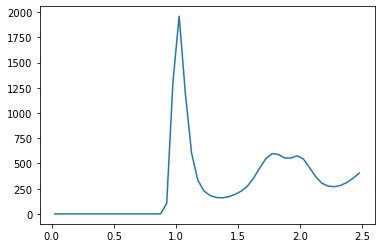

In [28]:
k = []
for i in range(50):
    k.append((i+1/2)*0.05)

plt.plot(k, v[-1])

In [13]:
print(2.5/0.05)

50.0


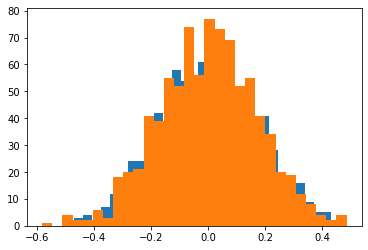

In [14]:
init_v = initialisation(1.38, 0.55)[1]
cinit = np.genfromtxt("test.txt", delimiter=" ").flatten()

plt.hist(cinit[::3], bins=30)
plt.hist(init_v[::3], bins=30)

plt.show()

0.5138685559973067


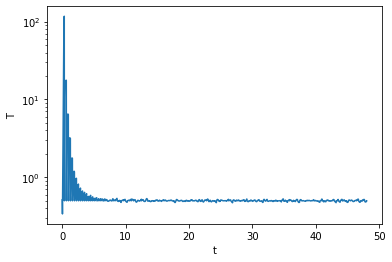

In [16]:
print(v[2][0])

plt.plot(v[1], v[2])
plt.yscale("log")
plt.xlabel("t")
plt.ylabel("T")
plt.show()

2592.0


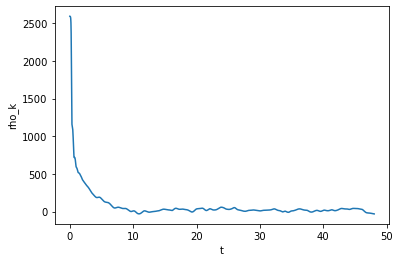

In [17]:
print(v[3][0])

plt.plot(v[1], v[3])
plt.xlabel("t")
plt.ylabel("rho_k")
plt.show()

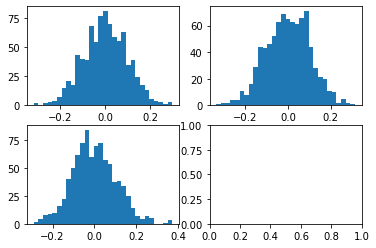

In [18]:

f, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].hist(v[0][::3], bins=30)
ax[1, 0].hist(v[0][1::3], bins=30)
ax[0, 1].hist(v[0][2::3], bins=30)
plt.show()

In [19]:
vel = np.genfromtxt("vel_dist_a.txt", delimiter=" ")
vel = vel.flatten()

k = []
for i in range(len(vel)):
    if i%4 != 3:
        k.append(vel[i])

T = temp(np.array(k))



print(T, temp(v[0]), v[2][-1])

1.324539155460562 0.5000000000000006 0.5000000000000006


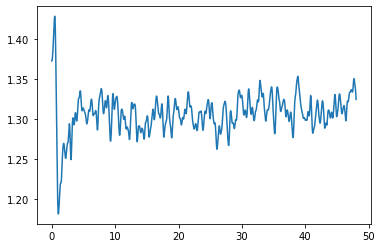

In [20]:
tempf = np.genfromtxt("temp_f.txt", delimiter=" ")

plt.plot(tempf[:, 0], tempf[:, 1])

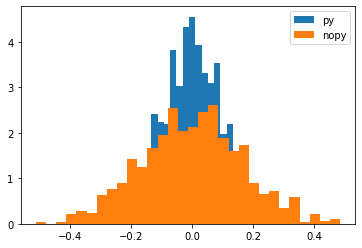

In [21]:


plt.hist(v[0][::3], bins=30, density=True, label="py")
plt.hist(vel[::4], bins=30, density=True, label="nopy")
plt.legend()

In [37]:
print(np.sum(v[0][::3]))
print(np.sum(vel[::4]))

3.6415315207705135e-14
9.343999987088125e-07


In [38]:
def temp1(vel):
    t = 0
    for i in range(N):
        for k in range(3):
            t+=vel[3*i+k]**2
    return mass * t / (3 * N)

print(temp1(v[0]))
print(temp1(k))

3.4794141109656915
1.3245391554605592


In [23]:
a = np.array([1, 1, 1])

print(np.linalg.norm(a), np.sqrt(3))

1.7320508075688772 1.7320508075688772
